In [80]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from natasha import Segmenter, MorphVocab, NewsNERTagger, NewsEmbedding, NewsMorphTagger, Doc
from trajectories import trajectory_from_text
from ordec import entropy_complexity
from ordec_borders import *

wdict = np.load('../russian_dict.npy', allow_pickle=True).item()
# wdict = {word: vec[-8:] for word, vec in wdict.items()}

In [7]:
with open('ВойнаиМир.txt', 'r', encoding='windows-1251') as f:
    txt = f.read()
    
print(txt[0:200])

part_1_idx = txt.find('Часть первая')
part_2_idx = txt.find('Часть вторая')
part1 = txt[len('Часть первая') + part_1_idx:part_2_idx]
part2 = txt[part_2_idx + len('Часть вторая'):]

with open('War_and_Peace_Book1_part1.txt', 'w', encoding='utf-8') as f:
    f.write(part1)
with open('War_and_Peace_Book1_part2.txt', 'w', encoding='utf-8') as f:
    f.write(part2)

Война и мир
Лев Николаевич Толстой


Коллекционное иллюстрированное издание
Роман «Война и мир», одно из величайших произведений русской и мировой литературы, создавался Л.Н. Толстым на протяжении шес


In [8]:
def prepare_russian_text(input_file, output_file):
    segmenter = Segmenter()
    emb = NewsEmbedding()
    morph_tagger = NewsMorphTagger(emb)
    ner_tagger = NewsNERTagger(emb)
    morph_vocab = MorphVocab()
    label_dict = {'NUM': 'ordinal1', 'PRON': 'pron1', 'PER': 'person1'}
    next_label_num = 5

    with open(input_file, encoding='utf-8') as fin:
        raw_text = ' '.join(fin.readlines()).replace('\n', ' ')
    raw_text = re.sub(r'\d+', '0', raw_text)
    raw_text = ' '.join(re.findall(r'[А-яЁё]+', raw_text))

    doc = Doc(raw_text)
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)

    for span in reversed(doc.ner.spans):
        if span.type not in label_dict:
            label_dict[span.type] = str(next_label_num)
            next_label_num += 1
        raw_text = "".join((raw_text[:span.start], label_dict[span.type], raw_text[span.stop:]))

    doc = Doc(raw_text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    prepared_text = ''
    prev_num = False
    for token in tqdm(doc.tokens, desc='Text preprocessing...'):
        if token.pos == 'NUM' and not token.text.isdigit():
            if not prev_num:
                prepared_text += '0'
                prepared_text += ' '
                prev_num = True
            continue
        prev_num = False
        if token.pos in label_dict:
            prepared_text += label_dict[token.pos]
            prepared_text += ' '
        elif token.pos != 'PUNCT':
            try:
                token.lemmatize(morph_vocab)
                prepared_text += token.lemma.lower()
                prepared_text += ' '
            except Exception as ex:
                prepared_text += token.text.lower()
                prepared_text += ' '

    with open(output_file, 'w', encoding='utf-8') as fout:
        fout.write(prepared_text)

In [9]:
prepare_russian_text('War_and_Peace_Book1_part1.txt', 'War_and_Peace_Book1_part1.txt')
prepare_russian_text('War_and_Peace_Book1_part2.txt', 'War_and_Peace_Book1_part2.txt')

Text preprocessing...:   0%|          | 0/46532 [00:00<?, ?it/s]

Text preprocessing...:   0%|          | 0/26174 [00:00<?, ?it/s]

In [10]:
with open('War_and_Peace_Book1_part1.txt', 'r', encoding='utf-8') as f:
    part1_preprocessed = f.read()

part1_ts = trajectory_from_text(part1_preprocessed, wdict, wdim=32, text_length_threshold=None)
print(f"Shape of the trajectory: {part1_ts.shape}")

Shape of the trajectory: (191499, 8)


In [11]:
n, m = 2, 8
ent, comp = entropy_complexity(part1_ts, n=n, m=m)
print(f"Entropy: {ent}, Complexity: {comp}")

Entropy: 0.665891020851857, Complexity: 0.4023167557406849


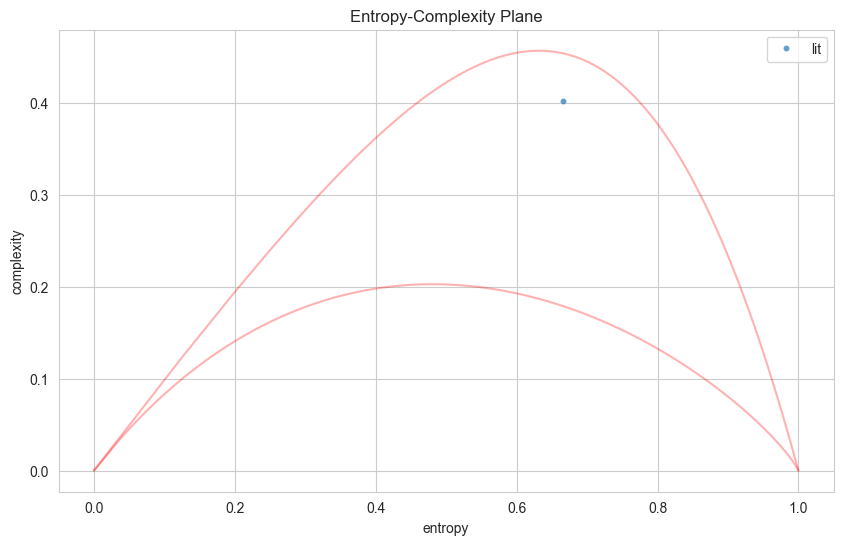

In [12]:
from ordec_borders import get_borders, plot_distributions

min_ec, max_ec = get_borders(n, m)

table = pd.DataFrame({
    'entropy': [ent],
    'complexity': [comp],
    'text_type': ['lit'],
    'lang' : 'ru',
    'n' : n,
    'm' : m
})

plt.figure(figsize=(10, 6))
plot_distributions(n, m, table=table, borders=(min_ec, max_ec), lang='ru', title="Entropy-Complexity Plane")
plt.show()

In [13]:
def split_text(text, num_parts):
    words = text.split()
    part_size = len(words) // num_parts
    parts = []
    for i in range(num_parts):
        start = i * part_size
        end = (i + 1) * part_size if i < num_parts - 1 else None
        parts.append(" ".join(words[start:end]))
    return parts

with open('War_and_Peace_Book1_part1.txt', 'r', encoding='utf-8') as f:
    text = f.read()
num_parts = 1000
parts = split_text(text, num_parts)

results_liter = []
for i, part in enumerate(tqdm(parts, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_liter.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })


Processing parts:   0%|          | 0/1000 [00:00<?, ?it/s]

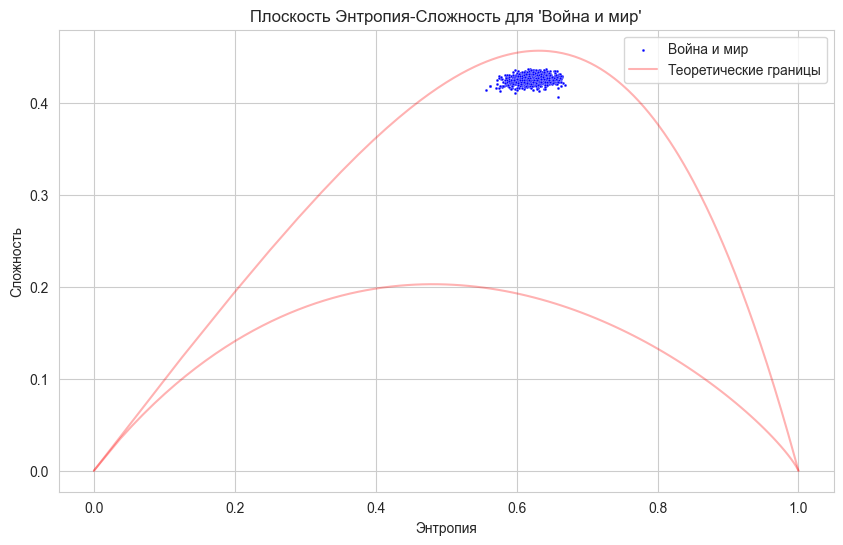

In [14]:
results_df_liter = pd.DataFrame(results_liter)

min_ec, max_ec = get_borders(n, m)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df_liter, x='entropy', y='complexity', s=4, color='blue', label='Война и мир')
sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='r', alpha=.3, label='Теоретические границы')
sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='r', alpha=.3)
# plt.xlim(0.5, 0.8)
# plt.ylim(0.43, 0.55)
plt.title("Плоскость Энтропия-Сложность для 'Война и мир'")
plt.xlabel("Энтропия")
plt.ylabel("Сложность")
plt.savefig('Voina_chaos_zoom.png')
plt.legend()
plt.show()

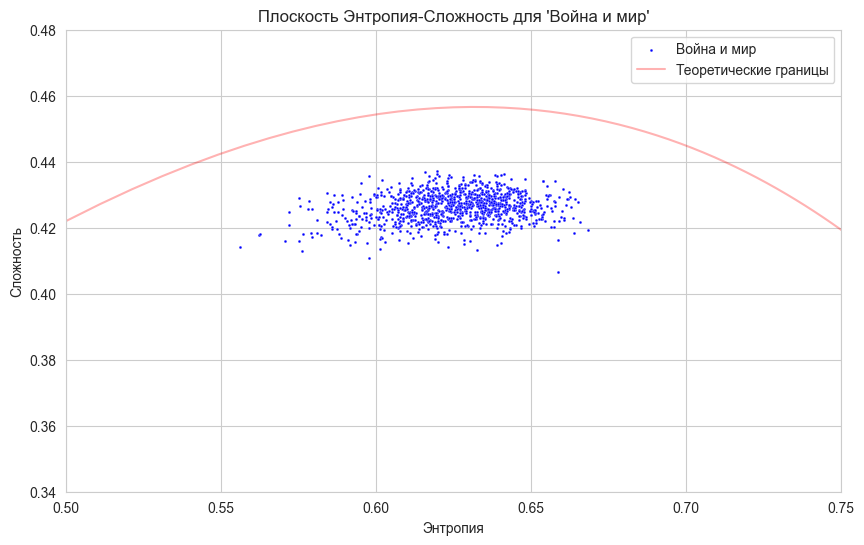

In [17]:
results_df_liter = pd.DataFrame(results_liter)

min_ec, max_ec = get_borders(n, m)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df_liter, x='entropy', y='complexity', s=4, color='blue', label='Война и мир')
sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='r', alpha=.3, label='Теоретические границы')
sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='r', alpha=.3)
plt.xlim(0.5, 0.75)
plt.ylim(0.34, 0.48)
plt.title("Плоскость Энтропия-Сложность для 'Война и мир'")
plt.xlabel("Энтропия")
plt.ylabel("Сложность")
plt.savefig('Voina_chaos_zoom.png')
plt.legend()
plt.show()

In [15]:
lemma_jokes = open('../anekdots_trunc.txt', 'r').read()
jokes = lemma_jokes.split('\n\n')

In [16]:
results_jokes = []
for i, part in enumerate(tqdm(jokes, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_jokes.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })

Processing parts:   0%|          | 0/87723 [00:00<?, ?it/s]

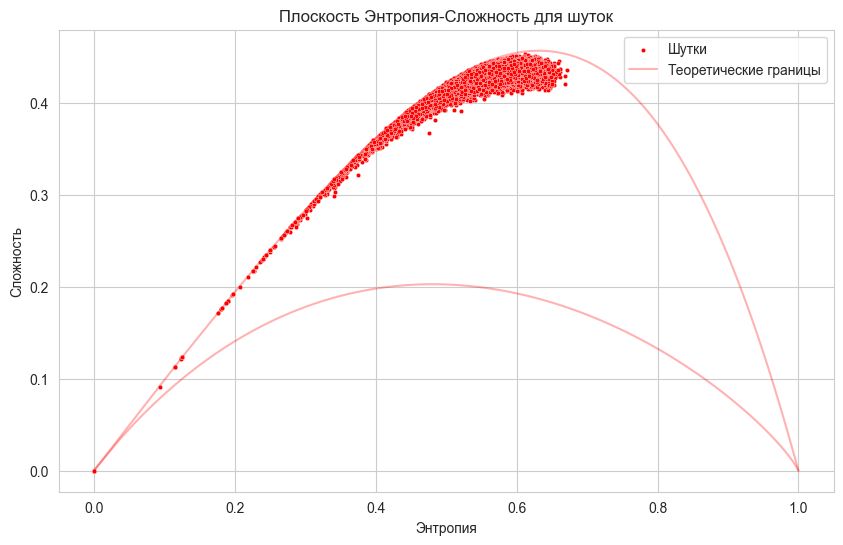

In [17]:
results_df_jokes = pd.DataFrame(results_jokes)

min_ec, max_ec = get_borders(n, m)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df_jokes, x='entropy', y='complexity', s=10, color='red', label='Шутки')
sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='r', alpha=.3, label='Теоретические границы')
sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='r', alpha=.3)
# plt.xlim(0.4, 1.0)
plt.title("Плоскость Энтропия-Сложность для шуток")
plt.xlabel("Энтропия")
plt.ylabel("Сложность")
plt.savefig('о.png')
plt.legend()
plt.show()

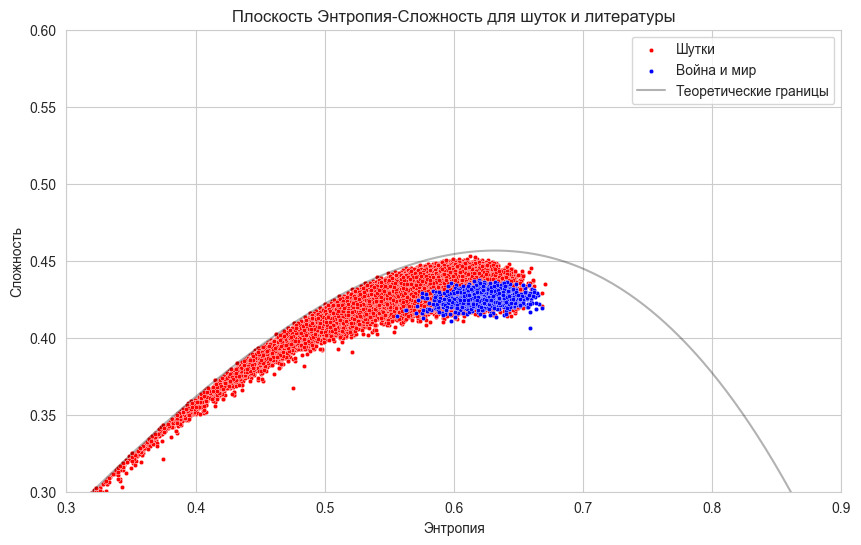

In [20]:
results_df = pd.DataFrame(results_df_liter)

min_ec, max_ec = get_borders(n, m)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df_jokes, x='entropy', y='complexity', s=10, color='red', label='Шутки')
sns.scatterplot(data=results_df_liter, x='entropy', y='complexity', s=10, color='blue', label='Война и мир')
sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', alpha=.3, label='Теоретические границы')
sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', alpha=.3)
plt.xlim(0.3, 0.9)
plt.ylim(0.3, 0.6)
plt.title("Плоскость Энтропия-Сложность для шуток и литературы")
plt.xlabel("Энтропия")
plt.ylabel("Сложность")
plt.legend()
plt.show()

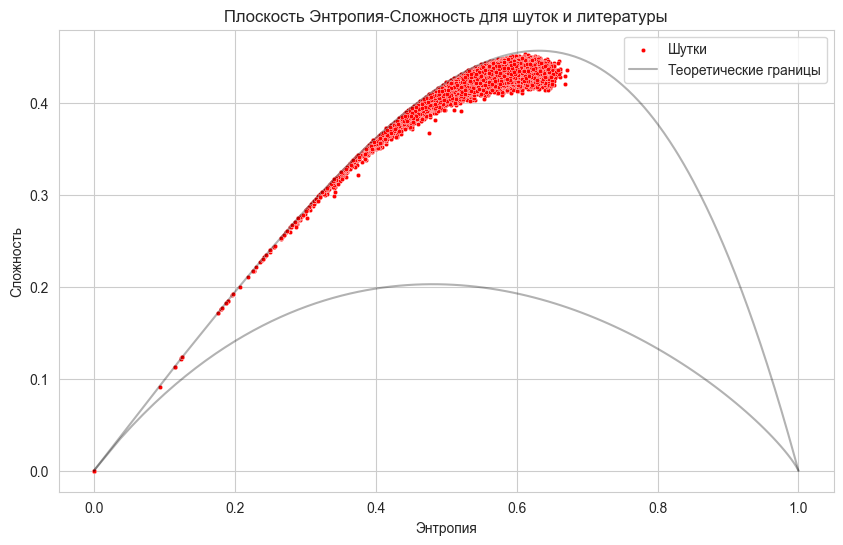

In [21]:
# with open('../lemma_literature.txt', 'r', encoding='utf-8') as f:
#     text = f.read()
# num_parts = 7000
# parts = split_text(text, num_parts)

# results_liter_lots = []
# for i, part in enumerate(tqdm(parts, desc="Processing parts")):
#     ts = trajectory_from_text(part, wdict, m)
#     if ts is not None:
#         ent, comp = entropy_complexity(ts, n=n, m=m)
#         results_liter_lots.append({
#             'part': i + 1,
#             'entropy': ent,
#             'complexity': comp,
#             'text_type': ['lit'],
#             'lang' : 'ru',
#             'n' : n,
#             'm' : m
#         })
        
# results_df_liter_lots = pd.DataFrame(results_liter_lots)

min_ec, max_ec = get_borders(n, m)

plt.figure(figsize=(10, 6))
# sns.scatterplot(data=results_df_liter_lots, x='entropy', y='complexity', s=10, color='blue', label='Литература')
sns.scatterplot(data=results_df_jokes, x='entropy', y='complexity', s=10, color='red', label='Шутки')
sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', alpha=.3, label='Теоретические границы')
sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', alpha=.3)
# plt.xlim(0.3, 0.9)
# plt.ylim(0.15, 0.5)
plt.title("Плоскость Энтропия-Сложность для шуток и литературы")
plt.xlabel("Энтропия")
plt.ylabel("Сложность")
plt.legend()
plt.show()

100%|███████████████████████████████████████████| 10/10 [00:59<00:00,  5.96s/it]


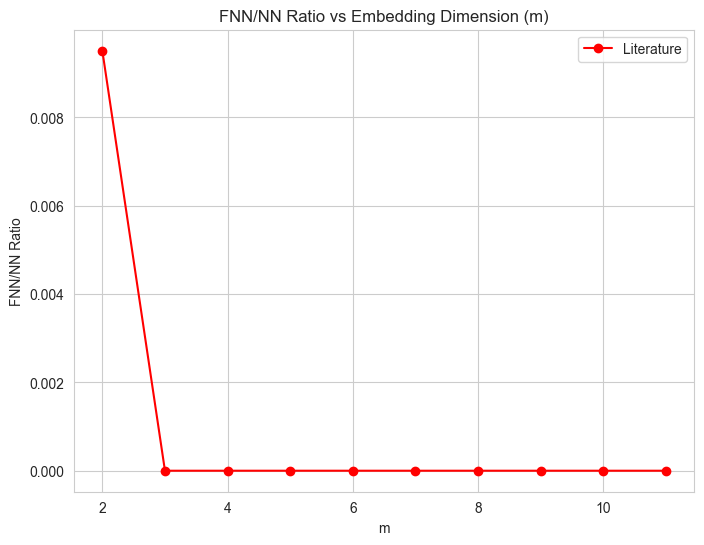

In [38]:
from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

def find_nn_and_fnn(m_first, z_vectors_m, z_vectors_m_plus_1):
    fnn_count = 0
    nn_count = 0
    n = len(z_vectors_m) - 1
    
    average_distance = np.mean([euclidean(z_vectors_m[i], z_vectors_m[j]) 
                                for i in range(len(z_vectors_m)) 
                                for j in range(i+1, len(z_vectors_m))])
    epsilon = 0.4 * average_distance
    

    for i in range(n):
        for j in range(i+1, n):
            distance = euclidean(z_vectors_m[i], z_vectors_m[j])
            if distance < epsilon:
                nn_count += 1
                distance_m_plus_1 = euclidean(z_vectors_m_plus_1[i], z_vectors_m_plus_1[j])
                if distance_m_plus_1 > 4 * epsilon:
                    fnn_count += 1
    
    return nn_count, fnn_count

fnns_liter = []
nns_liter = []

m_values = range(2, 12)

for m in tqdm(m_values):
    z_vectors_m = trajectory_from_text(text, wdict, wdim=m)[:1000]
    z_vectors_m_plus_1 = trajectory_from_text(text, wdict, wdim=m+1)[:1000]
    nn, fnn = find_nn_and_fnn(m, z_vectors_m, z_vectors_m_plus_1)
    fnns_liter.append(fnn)
    nns_liter.append(nn)

plt.figure(figsize=(8, 6))
plt.plot(m_values, [i/j for i, j in zip(fnns_liter, nns_liter)], marker='o', linestyle='-', color='r', label="Literature")
plt.xlabel("m")
plt.ylabel("FNN/NN Ratio")
plt.title("FNN/NN Ratio vs Embedding Dimension (m)")
plt.legend()
plt.grid(True)
plt.show()

In [118]:
n, m = 2, 8
lemma_jokes = open('../anekdots_trunc.txt', 'r').read()
jokes = lemma_jokes.split('\n\n')

wdict = np.load('../russian_dict_cbow.npy', allow_pickle=True).item()
wdict = {word: vec[-8:] for word, vec in wdict.items()}

In [119]:
print(np.mean([len(i.split()) for i in jokes]))

16.379603980712012


In [120]:
results_jokes = []
for i, part in enumerate(tqdm(jokes, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
#         if ent > 0.7:
#             print(part)
        results_jokes.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
results_df_jokes = pd.DataFrame(results_jokes)

Processing parts:   0%|          | 0/87723 [00:00<?, ?it/s]

In [121]:
min_ec, max_ec = get_borders(n, m)

with open('../lemma_literature.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    
num_parts = 80000 #len(jokes)
parts = split_text(text, num_parts)

results_liter_lots = []
for i, part in enumerate(tqdm(parts, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_liter_lots.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
        
results_df_liter_lots = pd.DataFrame(results_liter_lots)

Processing parts:   0%|          | 0/80000 [00:00<?, ?it/s]

In [122]:
# min_ec, max_ec = get_borders(n, m)

# with open('../lemma_literature.txt', 'r', encoding='utf-8') as f:
#     text = f.read()

# print(len(text.split()))
    
# num_parts = 11000 #len(jokes)
# parts = split_text(text, num_parts)

# results_liter_lots = []
# for i, part in enumerate(tqdm(parts, desc="Processing parts")):
#     ts = trajectory_from_text(part, wdict, m)
#     if ts is not None:
#         ent, comp = entropy_complexity(ts, n=n, m=m)
#         results_liter_lots.append({
#             'part': i + 1,
#             'entropy': ent,
#             'complexity': comp,
#             'text_type': ['lit'],
#             'lang' : 'ru',
#             'n' : n,
#             'm' : m
#         })
        
# results_df_liter_lots = pd.DataFrame(results_liter_lots)

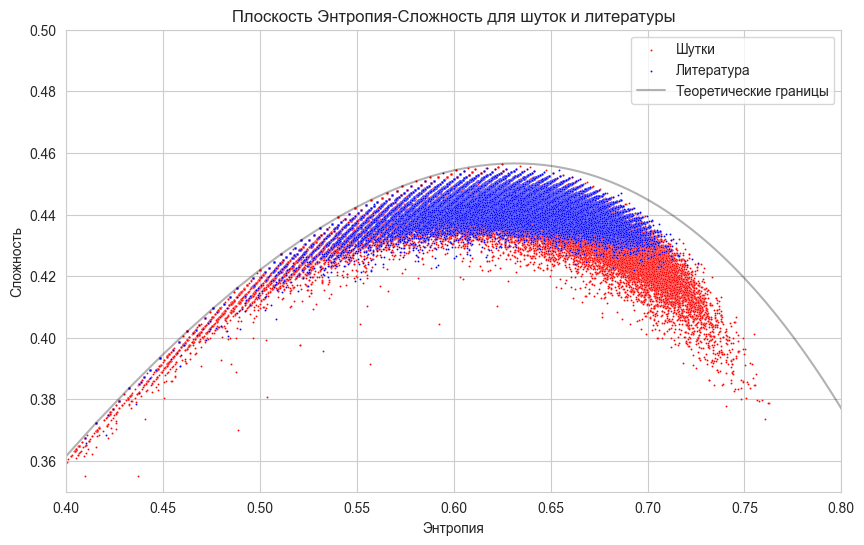

In [123]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df_jokes, x='entropy', y='complexity', s=2, color='red', label='Шутки')
sns.scatterplot(data=results_df_liter_lots, x='entropy', y='complexity', s=2, color='blue', label='Литература')
sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', alpha=.3, label='Теоретические границы')
sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', alpha=.3)
plt.xlim(0.4, 0.8)
plt.ylim(0.35, 0.5)
plt.title("Плоскость Энтропия-Сложность для шуток и литературы")
plt.xlabel("Энтропия")
plt.ylabel("Сложность")
plt.savefig('first.png')

plt.legend()
plt.show()

In [66]:
jokes_splitted = [' '.join(jokes[i-4:i]) for i in range(4, len(jokes), 4)]
print(np.mean([len(i.split()) for i in jokes_splitted]))

65.52065663474693


In [74]:
n, m = 3, 4
results_jokes = []
# for i, part in enumerate(tqdm(jokes_splitted, desc="Processing parts")):
for i, part in enumerate(tqdm(jokes, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_jokes.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
results_df_jokes = pd.DataFrame(results_jokes)

min_ec, max_ec = get_borders(n, m)

with open('../lemma_literature.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    
num_parts = 70000 #len(jokes)
parts = split_text(text, num_parts)

results_liter_lots = []
for i, part in enumerate(tqdm(parts, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_liter_lots.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
        
results_df_liter_lots = pd.DataFrame(results_liter_lots)

Processing parts:   0%|          | 0/87723 [00:00<?, ?it/s]

Processing parts:   0%|          | 0/70000 [00:00<?, ?it/s]

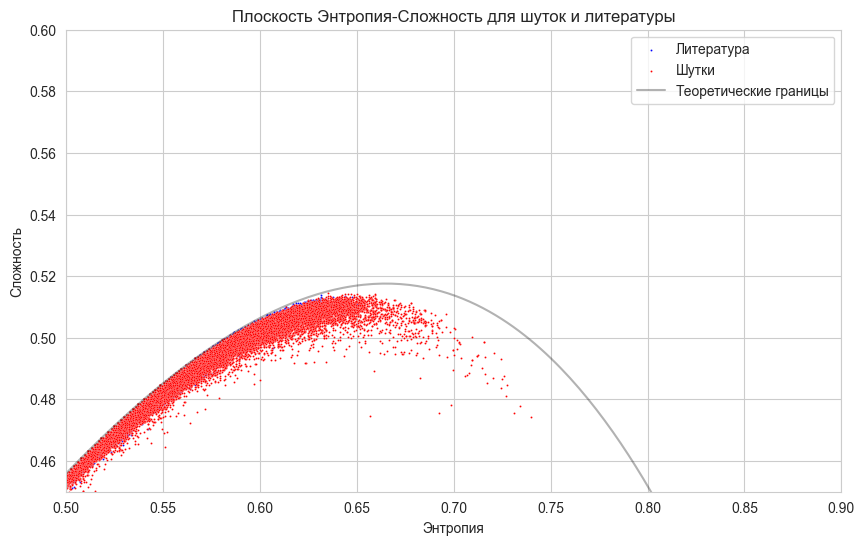

In [75]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df_liter_lots, x='entropy', y='complexity', s=2, color='blue', label='Литература')
sns.scatterplot(data=results_df_jokes, x='entropy', y='complexity', s=2, color='red', label='Шутки')
sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', alpha=.3, label='Теоретические границы')
sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', alpha=.3)
plt.xlim(0.4 + 0.1, 0.8 + 0.1)
plt.ylim(0.35 + 0.1, 0.5 + 0.1)
plt.title("Плоскость Энтропия-Сложность для шуток и литературы")
plt.xlabel("Энтропия")
plt.ylabel("Сложность")
plt.savefig('first.png')

plt.legend()
plt.show()

Processing parts:   0%|          | 0/87723 [00:00<?, ?it/s]

Processing parts:   0%|          | 0/11000 [00:00<?, ?it/s]

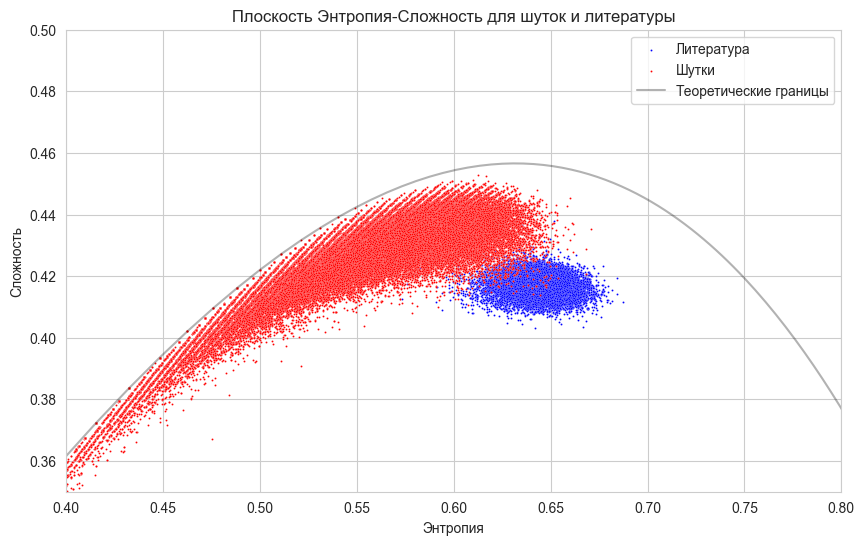

In [27]:
n, m = 2, 8
results_jokes = []
for i, part in enumerate(tqdm(jokes, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_jokes.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
results_df_jokes = pd.DataFrame(results_jokes)

min_ec, max_ec = get_borders(n, m)

with open('../lemma_literature.txt', 'r', encoding='utf-8') as f:
    text = f.read()
num_parts = 11000 #len(jokes)
parts = split_text(text, num_parts)

results_liter_lots = []
for i, part in enumerate(tqdm(parts, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_liter_lots.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
        
results_df_liter_lots = pd.DataFrame(results_liter_lots)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df_liter_lots, x='entropy', y='complexity', s=2, color='blue', label='Литература')
sns.scatterplot(data=results_df_jokes, x='entropy', y='complexity', s=2, color='red', label='Шутки')
sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', alpha=.3, label='Теоретические границы')
sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', alpha=.3)
plt.xlim(0.4, 0.8)
plt.ylim(0.35, 0.5)
plt.title("Плоскость Энтропия-Сложность для шуток и литературы")
plt.xlabel("Энтропия")
plt.ylabel("Сложность")
plt.legend()
plt.show()

In [54]:
n, m = 3, 4
# wdict = np.load('../russian_dict_cbow.npy', allow_pickle=True).item()
results_jokes = []
for i, part in enumerate(tqdm(jokes, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_jokes.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
results_df_jokes = pd.DataFrame(results_jokes)

min_ec, max_ec = get_borders(n, m)

with open('../lemma_literature.txt', 'r', encoding='utf-8') as f:
    text = f.read()
num_parts = 11000 #len(jokes)
parts = split_text(text, num_parts)

results_liter_lots = []
for i, part in enumerate(tqdm(parts, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_liter_lots.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
        
results_df_liter_lots = pd.DataFrame(results_liter_lots)

Processing parts:   0%|          | 0/87723 [00:00<?, ?it/s]

Processing parts:   0%|          | 0/11000 [00:00<?, ?it/s]

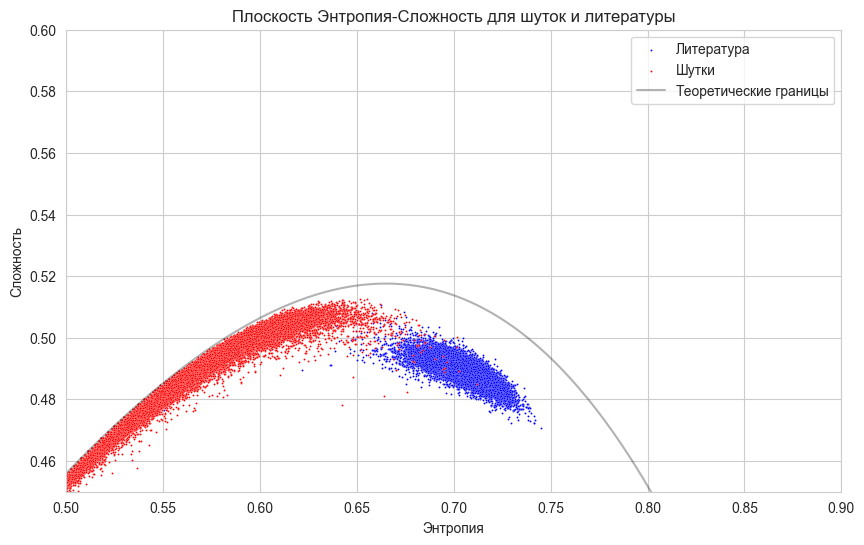

In [55]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df_liter_lots, x='entropy', y='complexity', s=2, color='blue', label='Литература')
sns.scatterplot(data=results_df_jokes, x='entropy', y='complexity', s=2, color='red', label='Шутки')
sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', alpha=.3, label='Теоретические границы')
sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', alpha=.3)
plt.xlim(0.4 + 0.1, 0.8 + 0.1)
plt.ylim(0.35 + 0.1, 0.5 + 0.1)
plt.title("Плоскость Энтропия-Сложность для шуток и литературы")
plt.xlabel("Энтропия")
plt.ylabel("Сложность")
plt.legend()
plt.show()

Processing parts:   0%|          | 0/87723 [00:00<?, ?it/s]

Processing parts:   0%|          | 0/11000 [00:00<?, ?it/s]

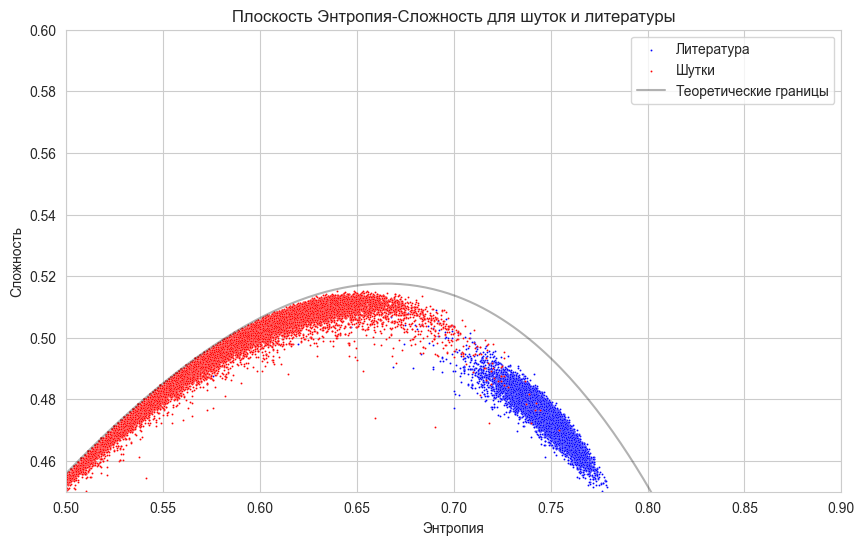

In [56]:
n, m = 3, 4
wdict = np.load('../russian_dict_cbow.npy', allow_pickle=True).item()
results_jokes = []
for i, part in enumerate(tqdm(jokes, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_jokes.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
results_df_jokes = pd.DataFrame(results_jokes)

min_ec, max_ec = get_borders(n, m)

with open('../lemma_literature.txt', 'r', encoding='utf-8') as f:
    text = f.read()
num_parts = 11000 #len(jokes)
parts = split_text(text, num_parts)

results_liter_lots = []
for i, part in enumerate(tqdm(parts, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_liter_lots.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
        
results_df_liter_lots = pd.DataFrame(results_liter_lots)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df_liter_lots, x='entropy', y='complexity', s=2, color='blue', label='Литература')
sns.scatterplot(data=results_df_jokes, x='entropy', y='complexity', s=2, color='red', label='Шутки')
sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', alpha=.3, label='Теоретические границы')
sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', alpha=.3)
plt.xlim(0.4 + 0.1, 0.8 + 0.1)
plt.ylim(0.35 + 0.1, 0.5 + 0.1)
plt.title("Плоскость Энтропия-Сложность для шуток и литературы")
plt.xlabel("Энтропия")
plt.ylabel("Сложность")
plt.legend()
plt.show()

Processing parts: 100%|█████████████████| 11000/11000 [00:10<00:00, 1024.82it/s]


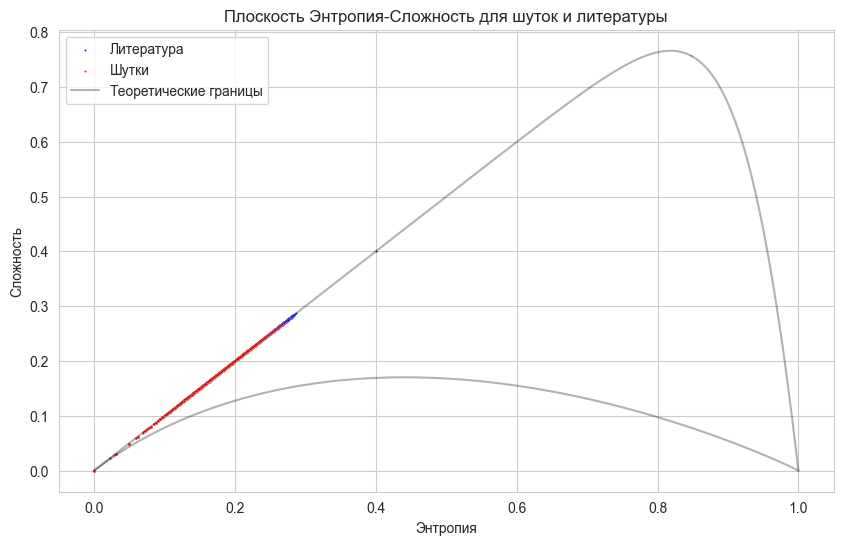

In [46]:
n, m = 4, 7
wdict = np.load('../russian_dict_cbow.npy', allow_pickle=True).item()
results_jokes = []
for i, part in enumerate(tqdm(jokes, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_jokes.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
results_df_jokes = pd.DataFrame(results_jokes)

min_ec, max_ec = get_borders(n, m)

with open('../lemma_literature.txt', 'r', encoding='utf-8') as f:
    text = f.read()
num_parts = 11000 #len(jokes)
parts = split_text(text, num_parts)

results_liter_lots = []
for i, part in enumerate(tqdm(parts, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_liter_lots.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
        
results_df_liter_lots = pd.DataFrame(results_liter_lots)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df_liter_lots, x='entropy', y='complexity', s=2, color='blue', label='Литература')
sns.scatterplot(data=results_df_jokes, x='entropy', y='complexity', s=2, color='red', label='Шутки')
sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', alpha=.3, label='Теоретические границы')
sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', alpha=.3)
# plt.xlim(0.4 + 0.1, 0.8 + 0.1)
# plt.ylim(0.35 + 0.1, 0.5 + 0.1)
plt.title("Плоскость Энтропия-Сложность для шуток и литературы")
plt.xlabel("Энтропия")
plt.ylabel("Сложность")
plt.legend()
plt.show()

Processing parts:   0%|          | 0/87723 [00:00<?, ?it/s]

Processing parts:   0%|          | 0/11000 [00:00<?, ?it/s]

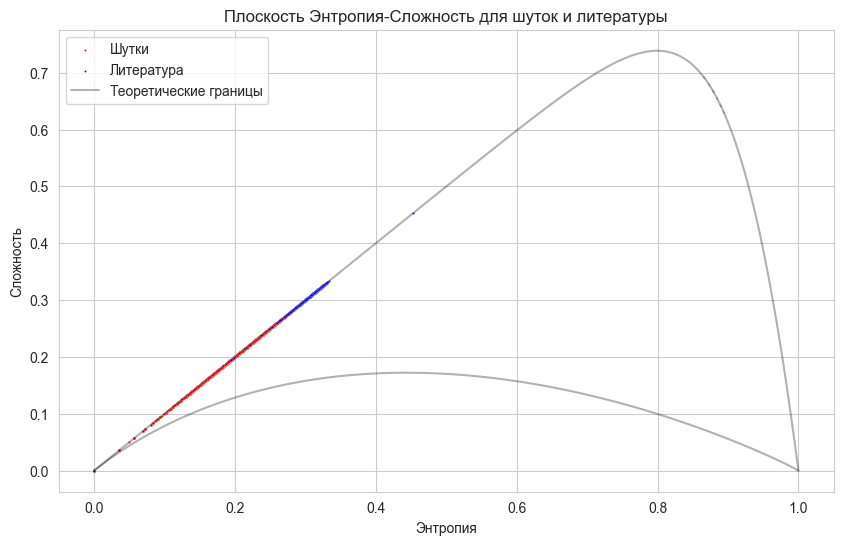

In [38]:
n, m = 4, 6
results_jokes = []
for i, part in enumerate(tqdm(jokes, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_jokes.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
results_df_jokes = pd.DataFrame(results_jokes)

min_ec, max_ec = get_borders(n, m)

with open('../lemma_literature.txt', 'r', encoding='utf-8') as f:
    text = f.read()
num_parts = 11000 #len(jokes)
parts = split_text(text, num_parts)

results_liter_lots = []
for i, part in enumerate(tqdm(parts, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_liter_lots.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
        
results_df_liter_lots = pd.DataFrame(results_liter_lots)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df_jokes, x='entropy', y='complexity', s=2, color='red', label='Шутки')
sns.scatterplot(data=results_df_liter_lots, x='entropy', y='complexity', s=2, color='blue', label='Литература')
sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', alpha=.3, label='Теоретические границы')
sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', alpha=.3)
# plt.xlim(0.4 + 0.1, 0.8 + 0.1)
# plt.ylim(0.35 + 0.1, 0.5 + 0.1)
plt.title("Плоскость Энтропия-Сложность для шуток и литературы")
plt.xlabel("Энтропия")
plt.ylabel("Сложность")
plt.legend()
plt.show()

Processing parts:   0%|          | 0/87723 [00:00<?, ?it/s]

Processing parts:   0%|          | 0/11000 [00:00<?, ?it/s]

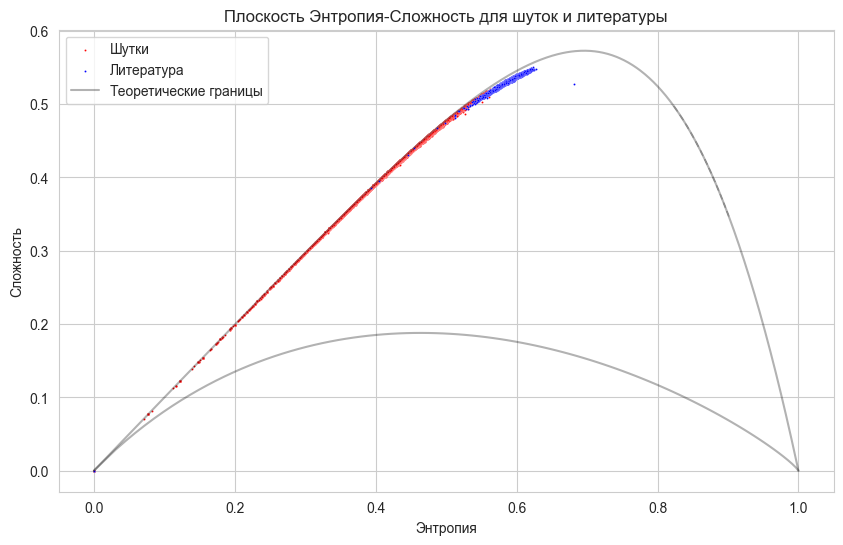

In [39]:
n, m = 5, 3
results_jokes = []
for i, part in enumerate(tqdm(jokes, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_jokes.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
results_df_jokes = pd.DataFrame(results_jokes)

min_ec, max_ec = get_borders(n, m)

with open('../lemma_literature.txt', 'r', encoding='utf-8') as f:
    text = f.read()
num_parts = 11000 #len(jokes)
parts = split_text(text, num_parts)

results_liter_lots = []
for i, part in enumerate(tqdm(parts, desc="Processing parts")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        results_liter_lots.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'text_type': ['lit'],
            'lang' : 'ru',
            'n' : n,
            'm' : m
        })
        
results_df_liter_lots = pd.DataFrame(results_liter_lots)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df_jokes, x='entropy', y='complexity', s=2, color='red', label='Шутки')
sns.scatterplot(data=results_df_liter_lots, x='entropy', y='complexity', s=2, color='blue', label='Литература')
sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', alpha=.3, label='Теоретические границы')
sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', alpha=.3)
# plt.xlim(0.4 + 0.1, 0.8 + 0.1)
# plt.ylim(0.35 + 0.1, 0.5 + 0.1)
plt.title("Плоскость Энтропия-Сложность для шуток и литературы")
plt.xlabel("Энтропия")
plt.ylabel("Сложность")
plt.legend()
plt.show()

In [58]:
m_values = range(1, 12)
z_vectors = {}
for m in m_values:
    z_vector_m = trajectory_from_text(text, wdict, wdim=m)
    z_vectors[m] = z_vector_m

In [59]:
from sklearn.neighbors import NearestNeighbors
def find_nn_and_fnn(z_vectors_m, z_vectors_m_plus_1, epsilon_multiplier=0.1):
    nn_m = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(z_vectors_m)
    distances_m, _ = nn_m.kneighbors(z_vectors_m)
    average_distance = np.mean(distances_m[:, 1])
    epsilon = epsilon_multiplier * average_distance
    
    nn_count = 0
    fnn_count = 0
    
    for i in range(len(z_vectors_m)):
        nn_distance_m = distances_m[i, 1]
        
        if nn_distance_m < epsilon:
            nn_count += 1
            
            nn_m_plus_1 = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(z_vectors_m_plus_1)
            distances_m_plus_1, _ = nn_m_plus_1.kneighbors(z_vectors_m_plus_1)
            nn_distance_m_plus_1 = distances_m_plus_1[i, 1]
            
            if nn_distance_m_plus_1 > 4 * epsilon:
                fnn_count += 1
    
    return fnn_count / nn_count if nn_count > 0 else 0